# Handling ARIA products using GDAL

**Author**: Emre Havazli, David Bekaert - Jet Propulsion Laboratory

ARIA products are distributed in netCDF4 format and include datasets related with the respective interferogram such as unwrapped phase, coherence, connected components, perpendicular and parallel baselines, amplitude, incidence, azimuth and look angles. We present here how to use GDAL capabilities while handling ARIA products in a python environment.

This notebook is intended to illustrate simple operations such as:
- opening an ARIA product and reading metadata, 
- accessing to subdatasets such as unwrapped phase, 
- reading the subdataset into an array and plotting, 
- cropping the subdataset to a given boundary
- creating KMZ files

To illustrate the usage of GDAL we will use data from ARIA system covering eastern United States between Cleveland, OH and Buffalo, NY with northern parts of the frame over Lake Erie.

If you have the filename of the product you would like to work with, you can download it using the wget command below. Make sure you the folder and filenames match with the data you want to use in the link below and change them accordingly. The folder names in the link below follows as:

../../interferogram/**version number**/**year**/**month**/**date**/**product folder name**/**product name**

wget --no-check-certificate --mirror -np -nH --reject "index.html*" --cut-dirs=7 http://hysds-aria.s3-website-us-west-2.amazonaws.com/datasets/interferogram/v2.0.1/2019/04/29/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc

In [1]:
!wget --no-check-certificate --mirror -np -nH --reject "index.html*" --cut-dirs=7 http://hysds-aria.s3-website-us-west-2.amazonaws.com/datasets/interferogram/v2.0.1/2019/04/29/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc

--2019-04-29 15:25:14--  http://hysds-aria.s3-website-us-west-2.amazonaws.com/datasets/interferogram/v2.0.1/2019/04/29/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
Resolving hysds-aria.s3-website-us-west-2.amazonaws.com (hysds-aria.s3-website-us-west-2.amazonaws.com)... 52.218.225.154
Connecting to hysds-aria.s3-website-us-west-2.amazonaws.com (hysds-aria.s3-website-us-west-2.amazonaws.com)|52.218.225.154|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-04-29 15:25:14 ERROR 404: Not Found.



## 0. Initial setup of the notebook

The cell below performs initial setup of the notebook and must be run every time the notebook is used. It loads the required modules into our python environment and using ***import*** command. We also enable exceptions for GDAL so we will be able to see GDAL generated errors in our notebook. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run before restarting.

In [2]:
import os,sys
from osgeo import gdal,osr
import numpy as np
import matplotlib.pyplot as plt

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

## 1. Opening an ARIA product and reading the metadata

### 1.1. Opening the product

We provide the location of our data file in the **fileName** and then simply call the **gdal.Open()** function

In [3]:
##Open netCDF file using GDAL##
fileName = './data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc'
ds = gdal.Open(fileName)

### 1.2 Reading the metadata

Now we can access to the metadata of the file and see how it is structured. The cell below shows how to read the metadata into a variable and then print it.

In [4]:
##Retrieve an overview of the file content##
dataInfo = gdal.Info(ds)
print(dataInfo)

Driver: netCDF/Network Common Data Format
Files: ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
       ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc.aux.xml
Size is 512, 512
Metadata:
  NC_GLOBAL#author=David Bekaert
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#institution=Jet Propulsion Laboratory
  NC_GLOBAL#ogr_geometry_field=productBoundingBox
  NC_GLOBAL#ogr_layer_name=productBoundingBox
  NC_GLOBAL#ogr_layer_type=POLYGON
  NC_GLOBAL#product_type=UNW GEO IFG
  NC_GLOBAL#references=https://aria.jpl.nasa.gov/
  NC_GLOBAL#source=Contains modified Copernicus Sentinel data processed by ESA and ARIA NASA/JPL
  NC_GLOBAL#title=ARIA standard product UNW GEO IFG
  NC_GLOBAL#version=1b
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":productBoundingBox
  SUBDATASET_1_DESC=[1x464] productBoundingBox (8-bit character)
  SUBDATASET_2_NAME=NETC

**This output can be generated by calling the shell command below**



In [ ]:
!gdalinfo ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc

## 2. Accessing to subdatasets

We can access to subdatasets, such as unwrapped phase, and their metadata the same way we accessed the products. We need to open the specific subdataset, which we can obtaing their location in the file using the information we printed above, and again read its metadata.

In [5]:
##Open and retrieve information of the unwrapped phase##

unwPhase = gdal.Open("NETCDF:"+fileName+":/science/grids/data/unwrappedPhase")
unwPhaseInfo = gdal.Info(unwPhase)
print(unwPhaseInfo)

Driver: netCDF/Network Common Data Format
Files: ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
       ./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc.aux.xml
Size is 4232, 2246
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (-81.866250000000022,42.667083333333366)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  /science/

**This output can be generated by calling the shell command below**


In [ ]:
!gdalinfo NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/grids/data/unwrappedPhase

### 2.1 Statistics of the dataset

The cell below is demonstrating how we can read the data and calculate its statistics using gdal in a python environment. The output is given in the order of min, max, mean and standard deviation. 

In [6]:
stats = unwPhase.GetRasterBand(1).GetStatistics(0,1)
print('Min: ', stats[0])
print('Max: ', stats[1])
print('Mean: ', stats[2])
print('Standard Dev.: ', stats[3])

Min:  -35.408046722412
Max:  20.177978515625
Mean:  -6.7323266167189
Standard Dev.:  4.2689717955368


**This output can be generated by calling the shell command below**

In [ ]:
!gdalinfo NETCDF:"./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/grids/data/unwrappedPhase -stats

## 3. Reading the subdataset into an array and plotting

### 3.1 Reading the subdataset into an array

Reading data sets into python arrays enables us to take advantage of the whole flexibility and operational capabilities of python. Here were are going to read our unwrapped phase into an array which is technically a 2D matrix in this case. Python arrays are not necessarily always matrices and have the capabililty to expand into n-dimensions. The cell below shows how to read unwrapped phase into a variable. We are using variable, unwPhase, which is the instance we opened the unwrapped phase subdataset in the previous cell and calling GetRasterBand(1). We are calling raster band 1 because our subdataset has only 1 band as we see in the output of the previous cell.

In [7]:
unwData = unwPhase.GetRasterBand(1).ReadAsArray()

### 3.2 Retrieving the information required for plotting

When we want to plot the data using python we need to extract some more information from the subdataset. We are going to need **"No Data Value"**, **"Projection"** and **"Corner Coordinates"**. The cell below shows how to extract this information from unwrapped phase subdataset.

In [8]:
##Get No Data Value##
NDV = unwPhase.GetRasterBand(1).GetNoDataValue()

##Get Projection##
projection = osr.SpatialReference()
projection.ImportFromWkt(unwPhase.GetProjectionRef())

##Get corner coordinates##
ulLon, Lonres, Lonskew, ulLat, Latskew, Latres  = unwPhase.GetGeoTransform()
lrLon = ulLon + (unwPhase.RasterXSize * Lonres)
lrLat = ulLat + (unwPhase.RasterYSize * Latres)

###Let's round corner coordinates to the same number of digits as given in previous cell###
ulLon = np.round(ulLon,7)
ulLat = np.round(ulLat,7)
lrLon = np.round(lrLon,7)
lrLat = np.round(lrLat,7)

###Corner coordinates taken from previous cell###
print('''
Corner Coordinates from previous cell:
Upper Left  ( -81.8662500,  42.6670833)
Lower Left  ( -81.8662500,  40.7954167)
Upper Right ( -78.3395833,  42.6670833)
Lower Right ( -78.3395833,  40.7954167)
''')

###Corner coordinates calculated in this cell###
print('''
Corner Coordinates calculated in this cell: ''',
'''Upper Left: ''', (ulLon,  ulLat),
'''Lower Left: ''', (ulLon,  lrLat),
'''Upper Right: ''', (lrLon,  ulLat),
'''Lower Right: ''', (lrLon,  lrLat), sep='\n')



Corner Coordinates from previous cell:
Upper Left  ( -81.8662500,  42.6670833)
Lower Left  ( -81.8662500,  40.7954167)
Upper Right ( -78.3395833,  42.6670833)
Lower Right ( -78.3395833,  40.7954167)


Corner Coordinates calculated in this cell: 
Upper Left: 
(-81.86625, 42.6670833)
Lower Left: 
(-81.86625, 40.7954167)
Upper Right: 
(-78.3395833, 42.6670833)
Lower Right: 
(-78.3395833, 40.7954167)


### 3.3 Masking the array 
After getting the required information for a plot let's do a final operation in the dataset and mask the no-data areas using the No Data Value (NDV) we got in the previous cell. We can carry out this operation using numpy module of python as below.

In [9]:
unwDataMasked = np.ma.masked_array(unwData, mask=unwData==NDV, fill_value=999999)

### 3.4 Plotting the data

We can use various methods to plot our dataset. The cell below is showing how to plot using Basemap module.

Before starting to use Basemap module, we need to make sure that our **PROJ_LIB** directory contains a file named **epsg** (NOT epsg.wkt). Unfortunately this file is not automatically installed with PROJ4 version 6 but it comes with the previous versions. Since we only installed previous versions to use with Basemap, we can copy the epsg file from that directory (in case of conda installation of Basemap, /python/install/dir/share/proj/epsg) to our **PROJ_LIB** directory (/my/proj/install/dir/share/proj)

Make sure that you have basemap-data-hires package installed for a high resolution plot. The command below can be used for Anaconda python installations.

conda install -c conda-forge basemap-data-hires

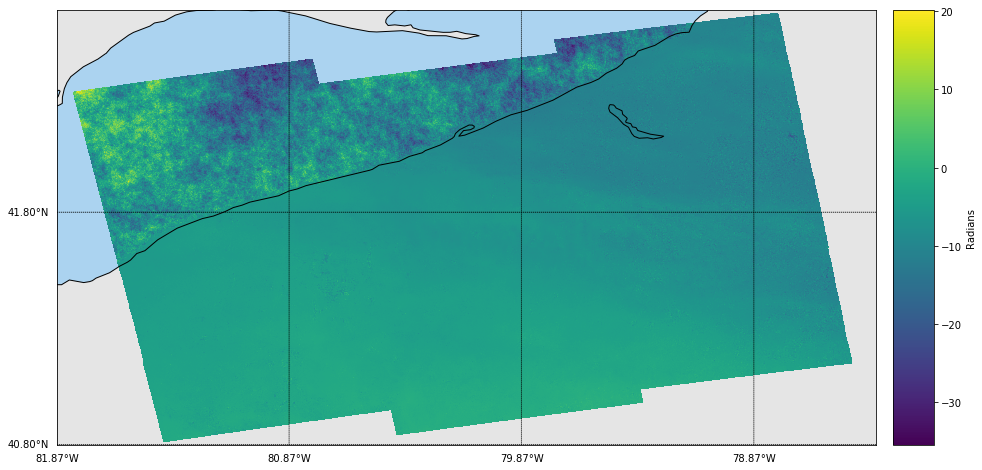

In [13]:
from mpl_toolkits.basemap import Basemap

plt.rcParams['figure.figsize'] = [20, 8]

#######The plot extend is image corners###########
m = Basemap(projection='cyl',
            ellps = 'WGS84',
            llcrnrlat = lrLat,
            llcrnrlon = ulLon,
            urcrnrlat = ulLat,
            urcrnrlon = lrLon,
            resolution='h')
##################################################

#######The plot extend is given coordinates#######
# m = Basemap(projection='cyl',
#             ellps = 'WGS84',
#             llcrnrlat = 40.75,
#             llcrnrlon = -82,
#             urcrnrlat = ulLat,
#             urcrnrlon = lrLon,
#             resolution='h')
##################################################

lats = np.linspace(lrLat,ulLat,unwDataMasked.shape[0])
lons = np.linspace(ulLon,lrLon,unwDataMasked.shape[1])
x, y = m(*np.meshgrid(lons,lats))

fig = m.pcolormesh(x,y,np.flipud(unwDataMasked),cmap='viridis')
fig = m.drawcoastlines()
# m.drawcountries(linewidth=2)
# m.drawstates(color='b')

fig = m.drawparallels(np.arange(m.latmin,m.latmax,1),labels=[1,0,0,0],fmt='%.2f')
fig = m.drawmeridians(np.arange(m.lonmin,m.lonmax,1),labels=[0,0,0,1],fmt='%.2f')
fig = m.colorbar(label='Radians')
fig = m.fillcontinents(color='0.8', lake_color='#73C2FB',alpha=0.5,zorder=0)




## 4. Cropping the data at given boundaries and creating KMZ files

### 4.1 Exporting the data as KMZ
In this section we are going to use gdal capability to export the data into a KMZ file which can be viewed in Google Earth. We can do this operation using the simple gdal.Translate function. We only need to define output name, input data (unwPhase) and the options. We define the options using gdal.ParseCommandLine() function which allows us to pass gdal_translate options in notebook environment.

**Note:** Be aware that input data here is not our python array but the unwPhase which we opened using gdal.Open in previous section.

In [177]:
translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png'))
kmzFile = gdal.Translate("unwrappedPhase.kmz", unwPhase, options=translateOptions)

**This output can be generated by calling the shell command below**


In [ ]:
!gdal_translate -of KMLSUPEROVERLAY -of KMLSUPEROVERLAY -scale -co format=png "NETCDF:./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc:/science/grids/data/unwrappedPhase" unwrappedPhaseCrop.kmz

### 4.2 Cropping the data and exporting as KMZ

By only adding the **projwin** option into gdal.TranslateOptions we can crop the data and export the cropped plot into a KMZ file

In [178]:
translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png -projwin -81.00 42.30 -80.00 41.50'))
kmzFileCrop = gdal.Translate("unwrappedPhaseCrop.kmz", unwPhase, options=translateOptions)

**This output can be generated by calling the shell command below**


In [ ]:
!gdal_translate -of KMLSUPEROVERLAY -of KMLSUPEROVERLAY -scale -co format=png -projwin -81.00 42.30 -80.00 41.50 "NETCDF:./data/S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc:/science/grids/data/unwrappedPhase" unwrappedPhaseCrop.kmz